# Programm zur Erkennung von Hunderassen

## Schritt 1: Daten laden und Aufteilen in Trainings- und Testdaten

In [7]:
# Importieren der notwendigen Bibliotheken
import os
import random
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
from skimage import io, transform
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
import copy
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def read_images_to_split(dataset_path, annotation_path):
    # Funktion zum Parsen der Annotationsdateien
    def parse_annotation(xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        bndboxes = []
        for obj in root.findall('object'):
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            bndboxes.append((xmin, ymin, xmax, ymax))
        return bndboxes

    # Laden der Bilder und Extrahieren der Hundebereiche
    images = []
    labels = []
    breeds = os.listdir(dataset_path)

    for breed in breeds:
        breed_img_path = os.path.join(dataset_path, breed)
        breed_anno_path = os.path.join(annotation_path, breed)
        if os.path.isdir(breed_img_path):
            for img_name in os.listdir(breed_img_path):
                img_path = os.path.join(breed_img_path, img_name)
                annotation_name = os.path.splitext(img_name)[0]
                annotation_file = os.path.join(breed_anno_path, annotation_name)
                if not os.path.exists(annotation_file):
                    continue  # Überspringe Bilder ohne Annotation
                image = io.imread(img_path)
                if image is None:
                    continue
                bndboxes = parse_annotation(annotation_file)
                for bndbox in bndboxes:
                    xmin, ymin, xmax, ymax = bndbox
                    xmin = max(0, xmin)
                    ymin = max(0, ymin)
                    xmax = min(image.shape[1], xmax)
                    ymax = min(image.shape[0], ymax)
                    if xmin >= xmax or ymin >= ymax:
                        continue  # Ungültige Bounding Box überspringen
                    cropped_image = image[ymin:ymax, xmin:xmax]
                    cropped_image = transform.resize(cropped_image, (256, 256))
                    images.append(cropped_image)
                    labels.append(breed)

    # Umwandeln der Labels in numerische Werte
    le = LabelEncoder()
    y = le.fit_transform(labels)

    # Konvertierung der Labels in One-Hot-Encoding
    y = to_categorical(y, 5)


    # Überprüfen, ob Bilder geladen wurden
    if len(images) == 0:
        print("Fehler: Keine Bilder geladen. Bitte überprüfen Sie den Pfad und die Annotationsdateien.")

    return np.array(images), y, le


In [ ]:
X, y, le = read_images_to_split("dogs", "annotations")

## 2. Schritt: Netzarchitektur festlegen

Convolutional Neural Networks (CNNs) eignen sich hervorragend für Bildklassifikationsaufgaben, da sie räumliche Strukturen in Bildern effektiv erkennen können. CNNs verwenden Faltungsoperationen, die es ihnen ermöglichen, lokale Merkmale wie Kanten, Texturen und Formen zu extrahieren, die für die Unterscheidung von Hunderassen essenziell sind.

**Gründe für die Wahl von CNNs:**

1. Parameterreduzierung: Durch Gewichtsteilung reduzieren CNNs die Anzahl der zu lernenden Parameter im Vergleich zu vollständig verbundenen Netzwerken. Dies ist insbesondere bei großen Eingabebildern (z. B. 256x256) wichtig.
2. Translation Invariance: CNNs können wichtige Merkmale unabhängig von deren Position im Bild erkennen, was bei der Hunderassenerkennung hilfreich ist, da die Hunde in unterschiedlichen Posen und Perspektiven dargestellt sein können.
3. Hierarchisches Lernen: CNNs lernen in den unteren Schichten einfache Merkmale (wie Kanten) und kombinieren diese in höheren Schichten zu komplexeren Merkmalen (z. B. Gesichtszüge von Hunden).

**Netzwerkarchitektur:**
Für die Hunderassenerkennung wähle ich folgende Architektur:

- *Eingabeschicht*: Input-Shape (256, 256, 3) (RGB-Bilder mit Größe 256x256).
- *Faltungsschichten (Convolutional Layers)*: Mehrere Schichten mit 3x3-Filtern und zunehmender Filteranzahl (z. B. 32, 64, 128), um unterschiedliche Merkmale zu extrahieren.
- *Pooling-Schichten (MaxPooling)*: Nach jeder Faltungsschicht zur Reduktion der räumlichen Dimension und zur Verhinderung von Überanpassung.
- *Batch-Normalisierung*: Um die Trainingsstabilität zu erhöhen und den Gradientenfluss zu verbessern.
- *Dropout*: Nach den Faltungsblöcken, um Überanpassung zu reduzieren.
- *Fully-Connected Layer*: Eine oder mehrere vollständig verbundene Schichten, um die gelernte Merkmalsrepräsentation in Klassen zu übersetzen.
- *Ausgabeschicht*: Softmax-Aktivierung mit so vielen Neuronen wie Hunderassenklassen.

## 3. Schritt: Netzarchitektur implementieren

In [4]:
# Netzwerkarchitektur
model = Sequential([
    # Input layer
    Input(shape=(256, 256, 3)),
    
    # Faltungsschicht 1
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Add other layers as needed

    # Faltungsschicht 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Faltungsschicht 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Übergang zu Fully-Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    # Ausgabeschicht
    Dense(5, activation='softmax')
])

# Netzwerkübersicht anzeigen
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,586,885 (112.87 MB)

 Trainable params: 29,586,437 (112.86 MB)

 Non-trainable params: 448 (1.75 KB)

## 4. Schritt: Wahl einer geeigneten Lossfunktion und eines Optimizers

**Loss-Funktion:** CategoricalCrossentropy <br>
Diese Funktion eignet sich für Multi-Klassen-Klassifikationsprobleme und misst die Divergenz zwischen den vorhergesagten Wahrscheinlichkeiten und den tatsächlichen Klassenlabels.

**Optimizer:** Adam <br>
Der Adam-Optimizer kombiniert die Vorteile von AdaGrad und RMSProp und passt die Lernrate für jeden Parameter dynamisch an. Er ist robust und effizient, besonders bei großen Datenmengen und komplexen Modellen.

In [5]:
# Kompilierung des Modells
model.compile(
    optimizer=Adam(learning_rate=0.001), # Die Learning Rate wird hier zur Standard Rate gesetzt um später den Unterschied besser sichtbar zu machen
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 5. Evaluation mit der Kreuzvalidierung

In [9]:
def visualize_history(history):
    history_dict = history.history

    # Loss-Werte
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    # Accuracy-Werte (falls verwendet)
    accuracy = history_dict.get('accuracy')
    val_accuracy = history_dict.get('val_accuracy')

    # Epochen erstellen
    epochs = range(1, len(loss) + 1)

    # Plot für den Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot für die Accuracy (nur, wenn verfügbar)
    if accuracy and val_accuracy:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
        plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

Fold 1:
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 762ms/step - accuracy: 0.3429 - loss: 47.9078 - val_accuracy: 0.3424 - val_loss: 77.2887
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 748ms/step - accuracy: 0.6192 - loss: 15.7708 - val_accuracy: 0.3969 - val_loss: 81.9126
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 736ms/step - accuracy: 0.6254 - loss: 7.5415 - val_accuracy: 0.2840 - val_loss: 88.2735
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 751ms/step - accuracy: 0.6914 - loss: 3.9787 - val_accuracy: 0.2996 - val_loss: 56.1114
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 741ms/step - accuracy: 0.6848 - loss: 2.5659 - val_accuracy: 0.3813 - val_loss: 40.3418
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 746ms/step - accuracy: 0.7068 - loss: 1.2957 - val_accuracy: 0.3930 - val_loss: 19.0425
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 746ms/step - accuracy: 0.7218 - loss: 0.9863 - val_accuracy: 0.3541 - val_loss: 28.0526
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 757ms/step - accuracy: 0.7808 - loss: 

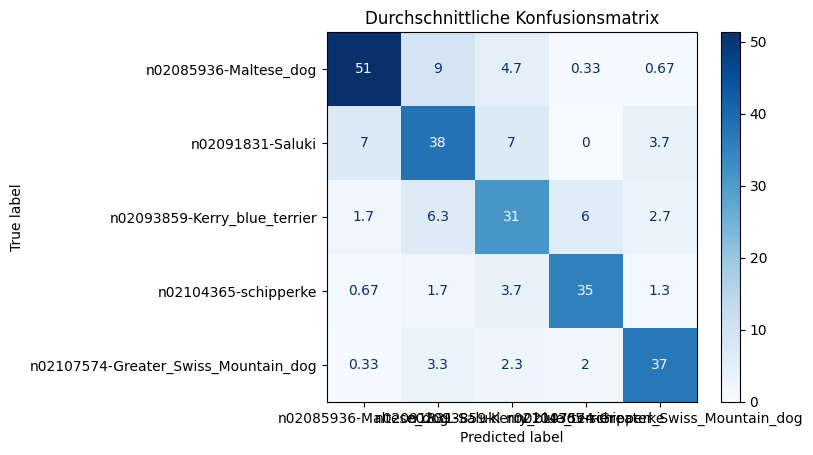

In [ ]:
# Kreuzvalidierung (3-fold)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold = 1
conf_matrices = []
histories = []
all_y_true = []
all_y_pred = []

for train_idx, val_idx in kf.split(X):
    print(f"Fold {fold} am Laufen")
    X_train_fold, X_val_fold =np.array(X)[train_idx], np.array(X)[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    
    # Training
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
              epochs=30, batch_size=16, verbose=0)
    
    # Graph des Verlauf des Trainings
    histories.extend(history)

    # Evaluation
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_val_int = np.argmax(y_val_fold, axis=1)

    # Speichern der Labels für den Report
    all_y_true.extend(y_val_int)
    all_y_pred.extend(y_pred_classes)

    
    # Speichern der Konfusionsmatrix
    conf_matrices.append(confusion_matrix(y_val_int, y_pred_classes))
    fold += 1

# History Visualisierung
avg_history = {
    'loss': np.mean([h.history['loss'] for h in histories], axis=0),
    'accuracy': np.mean([h.history['accuracy'] for h in histories], axis=0),
    'val_loss': np.mean([h.history['val_loss'] for h in histories], axis=0),
    'val_accuracy': np.mean([h.history['val_accuracy'] for h in histories], axis=0)
}
visualize_history(avg_history)

# Klassifizierungsbericht
print("\nKlassifizierungsbericht (Gesamtergebnis aus allen Folds):\n")
print(classification_report(all_y_true, all_y_pred, target_names=le.classes_))

# Mittelwert der Konfusionsmatrizen berechnen
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Visualisierung der Konfusionsmatrix
disp = ConfusionMatrixDisplay(confusion_matrix=avg_conf_matrix, display_labels=le.classes_, x_tick_rotation=45)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Durchschnittliche Konfusionsmatrix")
plt.show()


## Evaluation Aufgabe 5 

#### Precision
Precision misst den Anteil der korrekt als positiv klassifizierten Instanzen an allen als positiv klassifizierten Instanzen. In diesem Bericht variieren die Precision-Werte zwischen 0.59 und 0.78, was bedeutet, dass zwischen 59% und 78% der als jeweilige Hunderasse vorhergesagten Instanzen tatsächlich korrekt waren.

#### Recall
Recall misst den Anteil der korrekt als positiv klassifizierten Instanzen an allen tatsächlich positiven Instanzen. Hier liegen die Recall-Werte zwischen 0.53 und 0.89, was zeigt, dass das Modell zwischen 53% und 89% der tatsächlichen positiven Instanzen korrekt erkannt hat.

##### F1-Score
Der F1-Score ist der harmonische Mittelwert von Precision und Recall und dient als Maß für die Balance zwischen diesen beiden Metriken. In diesem Klassifikationsreport variieren die F1-Scores zwischen 0.63 und 0.83. Ein höherer F1-Score deutet darauf hin, dass das Modell sowohl in der Genauigkeit als auch in der Erkennungsrate gut abschneidet. Hier zeigt der F1-Score, dass das Modell insgesamt eine ausgewogene Leistung erbringt, indem es sowohl falsche positive als auch falsche negative Vorhersagen minimiert. Zum Beispiel, der Maltese Dog hat den höchsten F1-Score von 0.83, was bedeutet, dass das Modell für diese Klasse besonders gut funktioniert, während der Greater Swiss Mountain Dog mit einem F1-Score von 0.63 schlechter abschneidet, was in diesem Fall an dem schlechten Recall-Wert dieser Klasse liegt.

#### Zusammenfassung
Zusammengefasst zeigt das CNN-Modell solide Leistungen bei der Klassifikation der fünf Hunderassen mit einer durchschnittlichen Genauigkeit von 0,71, was deutlich über zufälligem Raten (20%) liegt, womit das Trainieren des Modells als Erfolg gewertet werden kann. Dass Schipperke und Greater Mountain Dog schlechter abschneiden, liegt vor allem daran, dass es weniger Bilder von diesen gibt, das Gegenteil gilt für den Maltese Dog, der die meisten Bilder hat und deshalb am besten abschneidet. 

Deshalb wäre ein Ansatz  die Genauigkeit zu erhöhen, dass man Rassen mit gleich vielen Bildern wählt. Man könnte auch den ähnlichen Ansatz der Data Augmentation wählen, um eine gleiche Anzahl von Daten pro Rasse zu schaffen.
Eine weitere Möglichkeit ist die generelle Erhöhung des Datensatzes, zum Beispiel durch externe Quellen.
Auch könnte man das Modell auf mehr Epochen laufen lassen und dann mit der Early Stopping Funktion ein Overfitting verhindern.


## 6. Transfer Learning

In [ ]:
# Entfernen der letzten drei Schichten und Hinzufügen neuer Schichten

new_model = copy.deepcopy(model)

new_model.pop()
new_model.pop()
new_model.pop()

# Hinzufügen neuer Schichten
new_model.add(Dense(256, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(5, activation='softmax'))


# Gefrorene Schichten (bis zur neuen Dense-Schicht)
for layer in new_model.layers[:-3]:  # Alle außer den neuen Schichten einfrieren
    layer.trainable = False

# Kompilieren des neuen Modells
new_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Überblick über das neue Modell
#new_model.summary()

# 
X_new, y_new, le_new = read_images_to_split("dogs_extended", "annotations")
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.25, stratify=y, random_state=42)


# Training der neuen Ausgabeschicht
new_model.fit(
    X_train_new, y_train_new,
    validation_data=(X_test_new, y_test_new),
    epochs=30, batch_size=16
)

# Feinabstimmung des gesamten Modells
for layer in new_model.layers:
    layer.trainable = True  # Alle Schichten freigeben

# Reduzierte Lernrate für Fine-Tuning
new_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

new_model.fit(
    X_train_new, y_train_new,
    validation_data=(X_test_new, y_test_new),
    epochs=5, batch_size=32
)

history_dict = history.history

# Loss-Werte
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Accuracy-Werte (falls verwendet)
accuracy = history_dict.get('accuracy')
val_accuracy = history_dict.get('val_accuracy')

# Epochen erstellen
epochs = range(1, len(loss) + 1)

# Plot für den Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot für die Accuracy (nur, wenn verfügbar)
if accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 318ms/step - accuracy: 0.4124 - loss: 31.8993 - val_accuracy: 0.5299 - val_loss: 14.5475
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 314ms/step - accuracy: 0.6676 - loss: 8.9018 - val_accuracy: 0.5641 - val_loss: 9.3394
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 314ms/step - accuracy: 0.7110 - loss: 3.8029 - val_accuracy: 0.5855 - val_loss: 6.4501
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 310ms/step - accuracy: 0.7659 - loss: 2.0242 - val_accuracy: 0.5256 - val_loss: 7.2142
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 310ms/step - accuracy: 0.7941 - loss: 1.9132 - val_accuracy: 0.5684 - val_loss: 6.7094
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 0.7627 - loss: 2.1846 - val_accuracy: 0.5598 - val_loss: 7.0329
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step - accuracy: 0.7699 - loss: 1.3101 - val_accuracy: 0.5940 - val_loss: 6.4504
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 324ms/step - accuracy: 0.7662 - loss: 1.3604 - val_ac

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step
                               precision    recall  f1-score   support

   n02089973-English_foxhound       0.81      0.53      0.64        49
 n02096294-Australian_terrier       0.63      0.59      0.61        46
         n02112018-Pomeranian       0.60      0.80      0.69        45
   n02113978-Mexican_hairless       0.67      0.68      0.67        41
n02116738-African_hunting_dog       0.72      0.77      0.75        53

                     accuracy                           0.68       234
                    macro avg       0.69      0.67      0.67       234
                 weighted avg       0.69      0.68      0.67       234



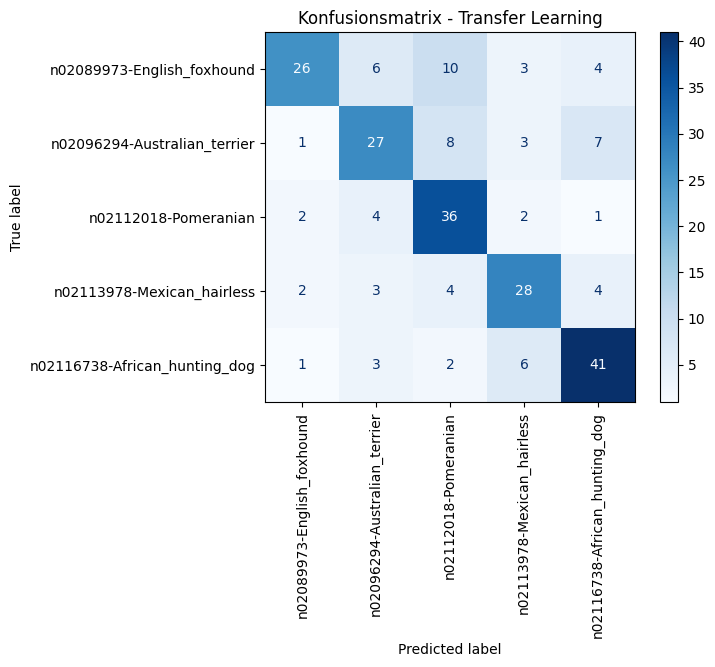

In [16]:
# Vorhersagen für Testdaten
y_pred_new = new_model.predict(X_test_new)

# Konvertiere die Vorhersagen zu Klassenindizes
y_pred_classes_new = np.argmax(y_pred_new, axis=1)
y_test_int_new = np.argmax(y_test_new, axis=1)

# Konfusionsmatrix
conf_matrix_new = confusion_matrix(y_test_int_new, y_pred_classes_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_new, display_labels=le_new.classes_)
disp_new.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Konfusionsmatrix - Transfer Learning")

#y_pred_classes_new = to_categorical(y_pred_classes_new)

#y_pred_classes_new = to_categorical(y_pred_classes_new)
report = classification_report(y_test_int_new, y_pred_classes_new, target_names=le_new.classes_)

print(report)


#plt.show()

## Evaluation Aufgabe 6

Das Modell aus Aufgabe 5 wurde kopiert, die letzten 3 Schichten entfernt (da die Schichten davor für die Feature Extraction sind) und dann wurden drei neue Schichten hinzugefügt, welche danach mit den neuen Daten trainiert wurden, um die Zuordnung der Features zu den Klassen neu festzulegen. Danach wurde noch ein Finetuning auf das gesamte Modell angewandt.
Trotz dessen hat das neue Modell mit den neuen Hunderassen eine schlechtere Genauigkeit (0,68(neues Modell) zu 0,71(altes Modell)), dieser Unterschied wäre eigentlich noch stärker, da bei diesem Modell die ausgewählten Hunderassen ungefähr gleich viele Bilder haben (was ja bei Aufgabe 5 nicht der Fall war).

Der Grund warum dieses Modell trotzdem schlechter abschneidet ist vermutlich unter anderem, weil die Feature Exraction auf die Hunde des ersten Modells angepasst ist.